In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy.io import fits
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

In [4]:
import os
import sys
sys.path.append('../tools/')

from dust_extinction import calALambda
from data_binning import data_binning
import glob

In [42]:
joj_bino = np.loadtxt('./data/ZTF22aajijjf_20230314_Binospec.ascii')
joj_lris = np.loadtxt('./data/ZTF22aajijjf_20230429_LRIS.ascii')
for joj in [joj_bino, joj_lris]:
    joj[:, 1] = joj[:, 1] * 10**(0.4 * calALambda(joj[:, 0], RV=3.1, EBV=0.04))
    joj[:, 2] = joj[:, 2] * 10**(0.4 * calALambda(joj[:, 0], RV=3.1, EBV=0.04))

joj_bino_bin = data_binning(joj_bino, size=5)
joj_lris_bin = data_binning(joj_lris, size=5)

z = 0.02736
MJD_peak = 59723.65
MJD_bino = 60017.42217
MJD_lris = 60061.559493
phase_bino, phase_lris = (np.array([MJD_bino, MJD_lris]) - MJD_peak) / (1 + z) + 0.51
phase_bino, phase_lris

(286.45861586979885, 329.42050167419325)

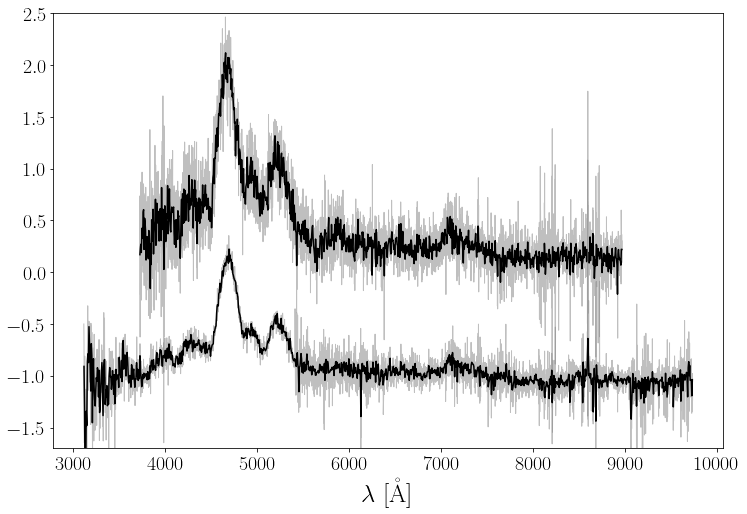

In [43]:
plt.figure(figsize=(12, 8))
for k in range(2):
    joj = [joj_bino, joj_lris][k]
    joj_bin = [joj_bino_bin, joj_lris_bin][k]
    plt.plot(joj[:, 0] / (1 + z), joj[:, 1] - k * 1.2, linewidth=1, color=".5", alpha=0.5)
    plt.plot(joj_bin[:, 0] / (1 + z), joj_bin[:, 1] - k * 1.2, color="k")
plt.xlabel(r"$\lambda\ [\mathrm{\mathring{A}}]$")
plt.ylim(-1.7, 2.5)
plt.show()

## Measure redshift with CCF

In [17]:
wav = joj_bino[:, 0]
fl = joj_bino[:, 1]

wv_grid_idx = np.argwhere((wav > 4200) & (wav < 6500)).ravel()
wv_grid = wav[wv_grid_idx]
fl_grid = fl[wv_grid_idx]

spec_lib = glob.glob('./Nebular_spec_lib/*')

def chi2_quadratic(params, obs, x):
    a, x0, y0 = params
    y = a * (x - x0)**2 + y0
    return np.sum((obs - y)**2)

from scipy.optimize import minimize

phases = []
names = []
specs = []
for k, spec in enumerate(spec_lib):
    with open(spec) as f:
        lines = f.readlines()
        for l in lines:
            if l.split()[0][0] == '#':
                if l.split()[1] == 'name':
                    name = l.split()[-1]
                if l.split()[1] == 'z':
                    z_spec = float(l.split()[-1])
                if l.split()[1] == 'phase':
                    phase = float(l.split()[-1])
                if l.split()[1] == 'E(B-V)':
                    ebv = float(l.split()[-1])
    if name == 'SN2006X': continue
    data = np.loadtxt(spec)
    data[:, 0] = data[:, 0] / (1+z_spec)
    data[:, 1] = data[:, 1] * 10**(0.4 * calALambda(data[:, 0], RV=3.1, EBV=ebv))
    specs.append(data)
    phases.append(phase)
    names.append(name)

index = np.argsort(phases).ravel()

phases = np.array(phases)

SN1999aa 256.0
0.0261

ASASSN-15be 266.0
0.0248

ASASSN-14jg 269.0
0.0253

SN1998bu 279.0
0.0264

SN1999aa 282.0
0.0266

SN2012hr 283.0
0.0243

SN2013cs 289.0
0.0236

SN2012fr 289.0
0.0244

SN2015F 289.0
0.0256

SN2011fe 289.0
0.0259

SN2007le 305.0
0.0245

SN2011by 310.0
0.0250

SN2011fe 313.0
0.0242

SN2005cf 317.0
0.0247

SN1991T 318.0
0.0242



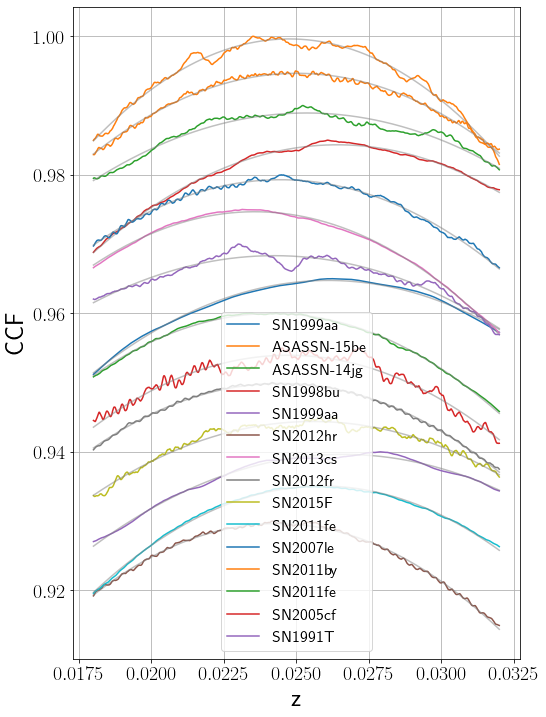

0.0250 +/- 0.0009


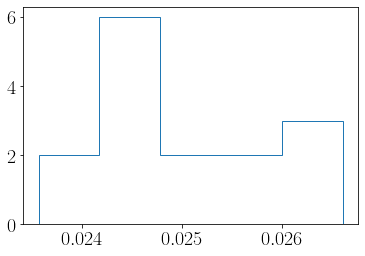

In [18]:
zs = np.linspace(0.018, 0.032, 1000)
plt.figure(figsize=(8, 12))
z_fit = np.ones_like(names, dtype=float)
for k in index:
    data = specs[k]
    CCF = np.array([np.nansum(np.interp(x=wv_grid, xp=data[:, 0] * (1+z), fp=data[:, 1]) * fl_grid) for z in zs])
    plt.grid()
    plt.plot(zs, CCF/CCF.max() - k * 5e-3, label=names[k])

    res = minimize(chi2_quadratic, x0=[-1, 0.025, 1], args=(CCF/CCF.max(), zs))
    a, z0, CCF0 = res.x
    fit = a * (zs - z0)**2 + CCF0
    plt.plot(zs, fit - k * 5e-3, color='0.5', alpha=.5)

    print(names[k], phases[k])
    print('{:.4f}'.format(z0))
    print()

    z_fit[k] = z0
    

plt.legend(prop={'size': 16})
plt.xlabel('z')
plt.ylabel('CCF')
plt.show()

_ = plt.hist(z_fit, histtype='step', bins=5)

print('{:.4f} +/- {:.4f}'.format(np.mean(z_fit), np.std(z_fit, ddof=1)))


In [12]:
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
import numpyro
import jax
import jax.numpy as jnp
import arviz as az


def numpyro_model():
    # z = k * (phase - 290) + b + sigma_int + sigma_ran
    theta = numpyro.sample("theta", dist.Uniform(-0.001, 0.001))
    b = numpyro.sample("b", dist.Normal(0.025, 0.001))
    log_sigma_int = numpyro.sample("log_sig_int", dist.Normal(-3, 1))
    sigma_int = numpyro.sample("sig_int", dist.Normal(
        jnp.zeros_like(phases), jnp.ones_like(phases) * 10**log_sigma_int))
    obs = numpyro.sample("obs", dist.Normal(jnp.tan(theta) * (jnp.asarray(phases) - 290) +
                         b + sigma_int, 0.0002), obs=z_fit)


sampler = MCMC(
    NUTS(numpyro_model),
    num_warmup=2000,
    num_samples=500,
    num_chains=2,
    progress_bar=True,
)
rng_key = jax.random.PRNGKey(114514)
sampler.run(rng_key)

trace = az.from_numpyro(sampler)
summary = az.summary(trace,
                     var_names=[
                         v for v in trace.posterior.data_vars
                         if v != "sig_int"
                     ], round_to=10)
print(summary)


/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_54561/2096724173.py:20: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = MCMC(
sample: 100%|██████████| 2500/2500 [00:00<00:00, 7956.62it/s, 15 steps of size 2.34e-02. acc. prob=0.94]


                 mean        sd    hdi_3%   hdi_97%  mcse_mean   mcse_sd  \
b            0.025048  0.000254  0.024539  0.025532   0.000021  0.000015   
log_sig_int -3.078209  0.087785 -3.217818 -2.895407   0.010894  0.007738   
theta       -0.000022  0.000013 -0.000043  0.000005   0.000002  0.000001   

               ess_bulk    ess_tail     r_hat  
b            153.617223  137.616426  1.031207  
log_sig_int   67.257210   95.525702  1.014692  
theta         66.616063   40.733937  1.040393  


Text(0, 0.5, 'z_fit')

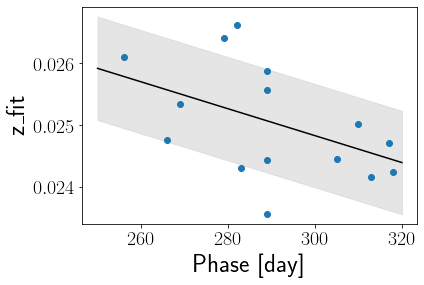

In [13]:
plt.errorbar(phases, z_fit, fmt='o')
phases_pred = np.linspace(250, 320, 2)
k_fit, b_fit = np.tan(summary['mean'].loc['theta']), summary['mean'].loc['b']
sig_int_fit = 10**summary['mean'].loc['log_sig_int']
plt.plot(phases_pred, (phases_pred - 290) * k_fit
         + b_fit, color='k')
plt.fill_between(phases_pred, (phases_pred - 290) * k_fit + b_fit - sig_int_fit,
                 (phases_pred - 290) * k_fit + b_fit + sig_int_fit, color='.8', alpha=.5)
plt.plot()
plt.xlabel('Phase [day]')
plt.ylabel('z_fit')


In [14]:
print('Estimated z at +287 days = {:.4f} +/- {:.4f}'.format((287 - 290) * k_fit + b_fit, sig_int_fit))

Estimated z at +287 days = 0.0251 +/- 0.0008


# Fit line velocities

In [20]:
from absorption_line_vel import SpectrumSN_Lines

# read spec data
z = 0.02736 #redshift
Spec_bino = SpectrumSN_Lines('./data/ZTF22aajijjf_20230314_Binospec-bin.ascii', z)
Spec_lris = SpectrumSN_Lines('./data/ZTF22aajijjf_20230426_LRIS.ascii', z)

## [Co iii] 6000

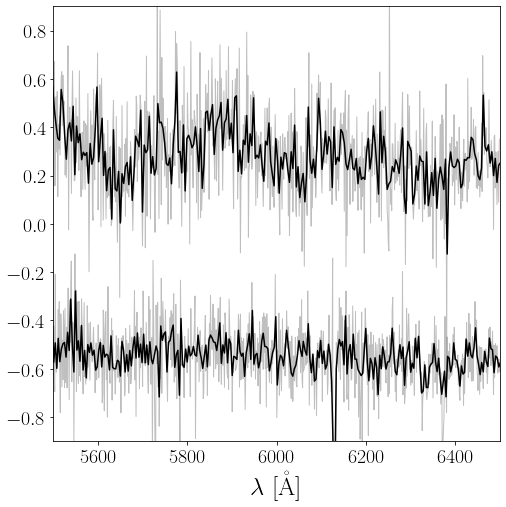

In [37]:
plt.figure(figsize=(8, 8))
for k in range(2):
    joj = [joj_bino, joj_lris][k]
    joj_bin = [joj_bino_bin, joj_lris_bin][k]
    plt.plot(joj[:, 0] / (1 + z), joj[:, 1] - k * .8, linewidth=1, color=".5", alpha=0.5)
    plt.plot(joj_bin[:, 0] / (1 + z), joj_bin[:, 1] - k * .8, color="k")
plt.xlabel(r"$\lambda\ [\mathrm{\mathring{A}}]$")
plt.ylim(-.9, .9)
# plt.axvline(6564.6, color='k')
# plt.axvline(6716.440 + 2, color='k')
plt.xlim(5500, 6500)
plt.show()

LS estimation:
Velocity 1: -785 km/s


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.


               mean       sd   hdi_16%   hdi_84%  mcse_mean  mcse_sd  \
v_mean[0]  -697.087  511.219 -1170.555  -185.914     11.459    9.190   
v_sig[0]   3021.708  754.091  2253.676  3709.960     21.249   15.131   
A[0]        909.892  267.623   609.438  1108.168      8.140    5.930   
sigma_0       0.196    0.026     0.172     0.224      0.000    0.000   
EW_0       -136.712   48.767  -170.771   -85.614      1.506    1.090   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  2105.153  1968.962  1.001  
v_sig[0]   1274.092  1886.029  1.005  
A[0]       1152.585  1312.683  1.005  
sigma_0    3211.550  1962.554  1.001  
EW_0       1146.732  1350.964  1.005  


(-1.0, 2.1)

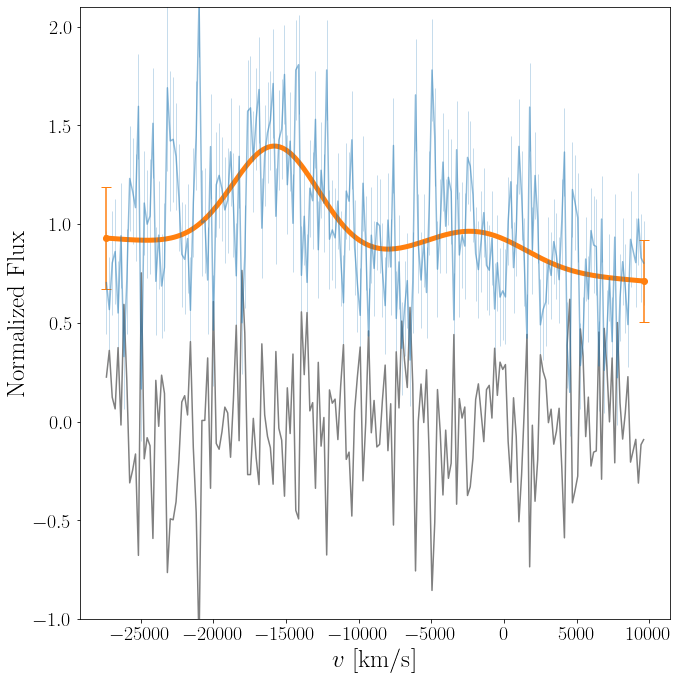

In [24]:
Spec_bino.add_line('[CoIII]', 5650, 6400, lines=[[5888.48, 5906.78, 6195.45, 6127.67]], rel_strength=[[12.6e3, 3.82e3, 3.78e3, 2.71e3]]) # Table 9, Storey & Sochi 2016
Spec_bino.line['[CoIII]'].LS_estimator(guess=(1, 1, -1000, 15, 1000))
_, _, ax = Spec_bino.line['[CoIII]'].MCMC_sampler(vel_mean_mu=[0], vel_mean_sig=[1e3])
ax.set_ylim(-1, 2.1)

## [Fe ii] 7300

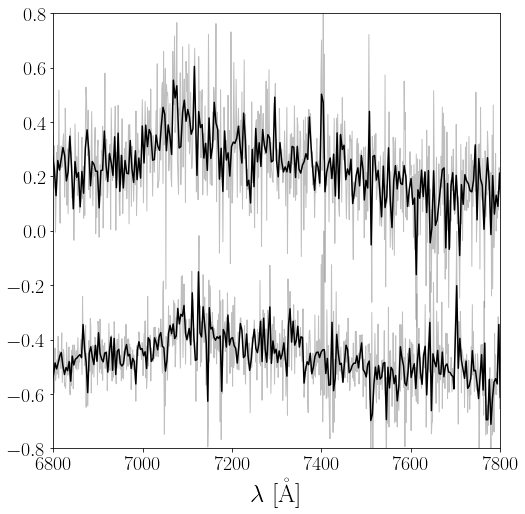

In [36]:
plt.figure(figsize=(8, 8))
for k in range(2):
    joj = [joj_bino, joj_lris][k]
    joj_bin = [joj_bino_bin, joj_lris_bin][k]
    plt.plot(joj[:, 0] / (1 + z), joj[:, 1] - k * .7, linewidth=1, color=".5", alpha=0.5)
    plt.plot(joj_bin[:, 0] / (1 + z), joj_bin[:, 1] - k * .7, color="k")
plt.xlabel(r"$\lambda\ [\mathrm{\mathring{A}}]$")
plt.ylim(-.8, .8)
# plt.axvline(6564.6, color='k')
# plt.axvline(6716.440 + 2, color='k')
plt.xlim(6800, 7800)
plt.show()

LS estimation:
Velocity 1: -2463 km/s


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


               mean       sd   hdi_16%   hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -2300.236  354.871 -2639.878 -1950.114      5.868    4.150   
v_sig[0]   3471.638  418.872  3039.080  3825.948      8.155    5.847   
A[0]       1517.081  171.476  1332.842  1657.852      3.586    2.559   
sigma_0       0.140    0.024     0.119     0.165      0.001    0.000   
EW_0       -317.893   48.668  -359.542  -268.508      1.032    0.741   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3716.742  2347.265  1.000  
v_sig[0]   2731.379  2550.114  1.001  
A[0]       2320.342  2225.210  1.000  
sigma_0    2466.856  1406.137  1.001  
EW_0       2295.471  2268.602  1.000  


(-1.0, 2.1)

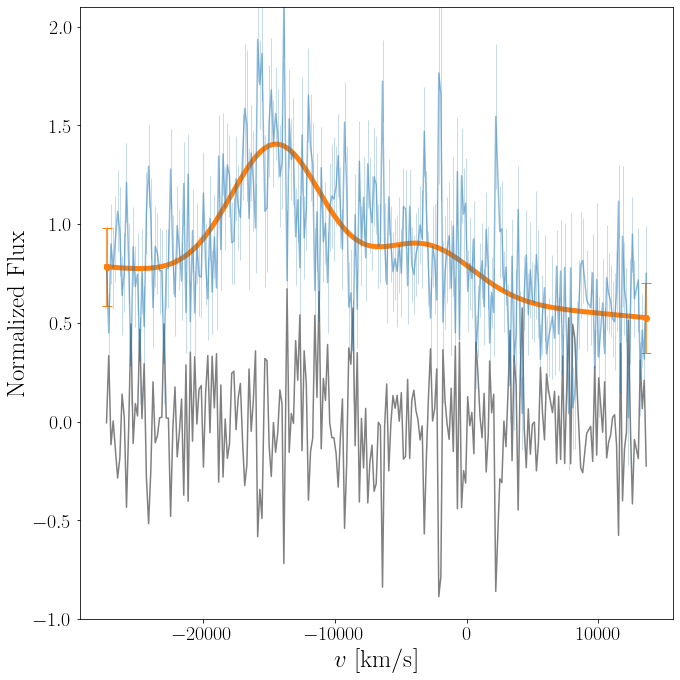

In [32]:
Spec_bino.add_line('[FeII]_7300', 6800, 7800, lines=[[7155, 7172, 7388, 7453]], rel_strength=[[1, 0.24, 0.19, 0.31]]) # Jerkstrand et al. 2015
Spec_bino.line['[FeII]_7300'].LS_estimator(guess=(1, 1, -1000, 15, 1000))
_, _, ax = Spec_bino.line['[FeII]_7300'].MCMC_sampler(vel_mean_mu=[-1e3], vel_mean_sig=[1e3])
ax.set_ylim(-1, 2.1)

LS estimation:
Velocity 1: -1244 km/s


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.6904, but should be close to 0.8. Try to increase the number of tuning steps.


               mean       sd   hdi_16%   hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -1321.304  395.009 -1710.973  -958.241      6.727    4.869   
v_sig[0]   4402.858  604.903  3755.753  4854.775     15.047   11.065   
A[0]       1448.696  172.287  1264.989  1581.319      4.375    3.206   
sigma_0       0.163    0.019     0.145     0.179      0.000    0.000   
EW_0       -236.767   35.930  -262.176  -197.802      0.937    0.692   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3486.042  3047.705  1.000  
v_sig[0]   1883.957  1631.957  1.003  
A[0]       1732.295  1490.109  1.004  
sigma_0    2303.587  1320.373  1.002  
EW_0       1676.502  1348.668  1.004  


(-1.0, 2.1)

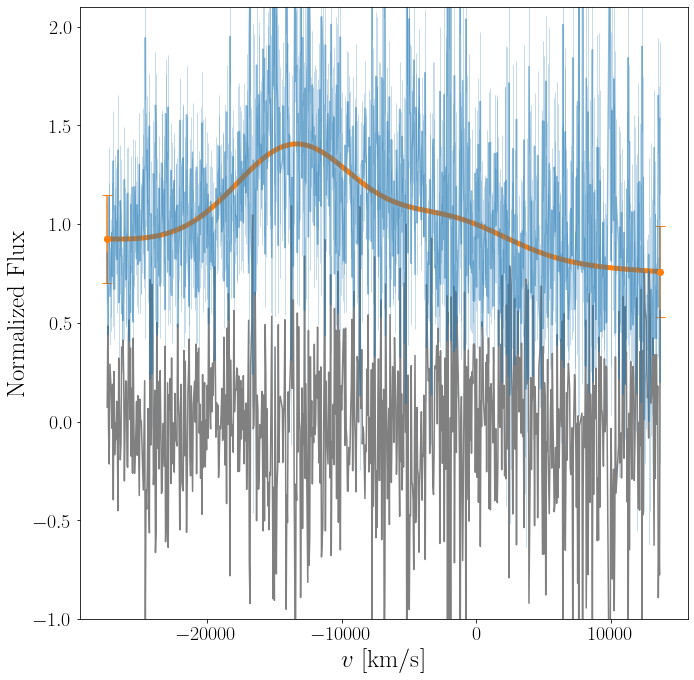

In [33]:
Spec_lris.add_line('[FeII]_7300', 6800, 7800, lines=[[7155, 7172, 7388, 7453]], rel_strength=[[1, 0.24, 0.19, 0.31]]) # Jerkstrand et al. 2015
Spec_lris.line['[FeII]_7300'].LS_estimator(guess=(1, 1, -1000, 15, 1000))
_, _, ax = Spec_lris.line['[FeII]_7300'].MCMC_sampler(vel_mean_mu=[-1e3], vel_mean_sig=[1e3])
ax.set_ylim(-1, 2.1)